In [1]:
# work in progress

# for experimental / educational purposes only
# -> see src.experiments.calibration for the actual implementation

In [2]:
import sys
from pathlib import Path
PROJECT_DIR = Path.cwd()
if PROJECT_DIR.stem == 'notebooks':
    PROJECT_DIR = PROJECT_DIR.parent
    sys.path.insert(0, '..')

INTERACTIVE_PLOTTING = True

# Overview

In [3]:
# NOTE
# Calibration consists of multiple sections pertaining:
#   - parameter estimation/validation 
#   - experimental instructions

# Pain threshold estimation
# Section 1: Preexposure to thermal stimuli
#   - familiarize the subject with the thermal stimuli
#   - binary responses to thermal stimuli
#   - Q: what kind of binary response? -> only asked at the end, if painful, mean is higher
#   - how many trials? how many temperatures? do we use the results?
# Section 2: Probabilistic pain threshold detection
#   - Bayesian adaptive design / sequential Bayesian design to:
#        1. update belief about the heat pain threshold and
#        2. decide on the temperature for the next trial.
#   - binary responses
#   - DONE

# Purely didactic for rating training
# Peri- or suprathreshold calibration
# Section 3: Scale translation
#   - didactic trials to support the transition from binary responses (Sections 1&2) to VAS responses
#   - purely instructional, to be done in psychopy
#   - Q: do I need this
# Section 4: Rating training
#   - Low intensities are applied exclusively to familiarize the subject with the visuomotor demands of the VAS scale
#   - Q: do I need this?

# Section 5: Psychometric-perceptual scaling
#   - (Section 5, includes all steps up to Section 6)
#   - Fixed temperature increments to familiarize subject with possible perceptual range
#   - Fixed intensity target regression: Perithresholding with fixed temperature increments, e.g. +0.5 °C, +1 °C
#   - Fixed VAS target regression: Perithresholding with fixed VAS targets, e.g. inferred temperatures for 30 VAS, 60 VAS
#   - Adaptive VAS target regression: Perithresholding to elaborate poorly sampled areas of the VAS range
#   - Q: How does this work? What is the difference between fixed intensity target regression and fixed VAS target regression?


# Section 6: Calibration validation
#   - apply results from Section 5 for a number of trials, e.g. to assess robustness

In [4]:
# TODO
# - ask andreas for values

In [5]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [6]:
import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
if not logger.handlers:  # Check if the logger already has a handler for use in e.g. jupyter notebooks
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter('%(levelname)s: %(message)s'))
    logger.addHandler(handler)

## Section 1: Preexposure to thermal stimuli

In [7]:
# Values from matlab setting script:

# % Preexposure (e.g. CalibHeat Section 1)
# P.calib.heat(n).preexposure.sInitCross  = 5; % forced wait after instructions/transitions
# P.calib.heat(n).preexposure.sInitCue    = 2; % in addition to sInitCross
# P.calib.heat(n).preexposure.intensities = [42 42.5 43 43.5]; % vector of intensities used for preexposure, intended to lead to binary decision "were any of these painful y/n"
# P.calib.heat(n).preexposure.sPlateau    = 10; 
# P.calib.heat(n).preexposure.sMinMaxITIs = [5 5]; 
# P.calib.heat(n).preexposure.sMinMaxCues = [2 2]; % in addition to sMinMaxITIs                 


In [8]:
preexposure_temperatures = [34, 35, 36, 37]
# TODO: add for loop and time.sleep() for each temperature
response = input(f'Were any of the preexposure stimuli ({str(preexposure_temperatures)} °C) painful? (y/n) ')
if response == "y":
    mean_temperature = 37
    logger.info(f"Calibration preexposure was painful. Starting temperature for pain threshold estimation: {mean_temperature} °C.")
else:
    mean_temperature = 39
    logger.info(f"Calibration preexposure was not painful. Starting temperature for pain threshold estimation: {mean_temperature} °C.")


INFO: Calibration preexposure was not painful. Starting temperature for pain threshold estimation: 39 °C.


## Section 2: Probabilistic pain threshold estimation

In [9]:
# Step 1: Define a prior probability distribution for the heat pain threshold
min_temperature = mean_temperature - 6
max_temperature = mean_temperature + 6
num_steps = int((max_temperature - min_temperature) / 0.1) + 1
range_temperature = np.linspace(min_temperature, max_temperature, num_steps) # note: do not use arange for floats
std_temperature = 4

likelihood_std = 1
reduction_factor = 0.9

prior = stats.norm.pdf(
    range_temperature, 
    loc=mean_temperature, 
    scale=std_temperature)
prior /= np.sum(prior)  # normalize to make it a valid probability distribution

# Step 2: Start the experiment with a predetermined temperature
current_temperature = np.round(
    range_temperature[np.argmax(prior)],
    1) # = mean_temperature from prior

# Step 3-end: Repeat for each trial
temperatures = [current_temperature]
priors = []
likelihoods = []
posteriors = []
trials = 7

for trial in range(trials):
    # Collect the subject's response
    response = input(f'Is {current_temperature} °C painful? (y/n) ')

    # Define a cdf likelihood function based on the response
    if response == 'y':
        logger.info(f"Calibration pain threshold trial {trial+1}: {current_temperature} °C was painful.")
        likelihood = 1 - stats.norm.cdf(
            range_temperature, 
            loc=current_temperature, 
            scale=likelihood_std)
    else:
        logger.info(f"Calibration pain threshold trial {trial+1}: {current_temperature} °C was not painful.")
        likelihood = stats.norm.cdf(
            range_temperature,
            loc=current_temperature, 
            scale=likelihood_std)

    # Decrease the standard deviation of the likelihood function as we gain more information
    likelihood_std *= reduction_factor

    # Update the prior distribution with the likelihood function to get a posterior distribution
    posterior = likelihood * prior
    posterior /= np.sum(posterior)  # normalize
    
    # Choose the temperature for the next trial based on the posterior distribution
    current_temperature = np.round(
        range_temperature[np.argmax(posterior)],
        1) # temperature with highest probability

    # Store the distributions and temperature
    priors.append(prior)
    likelihoods.append(likelihood)
    posteriors.append(posterior)
    temperatures.append(current_temperature)
    
    # Update the prior for the next iteration
    prior = np.copy(posterior)

vas_0 = temperatures[-1]
logger.info(f"Calibration pain threshold steps: {np.diff(temperatures)} °C.\n")
logger.info(f"Calibration pain threshold estimate: {vas_0} °C")

INFO: Calibration pain threshold trial 1: 39.0 °C was not painful.
INFO: Calibration pain threshold trial 2: 40.7 °C was not painful.
INFO: Calibration pain threshold trial 3: 42.0 °C was not painful.
INFO: Calibration pain threshold trial 4: 43.0 °C was not painful.
INFO: Calibration pain threshold trial 5: 43.9 °C was not painful.
INFO: Calibration pain threshold trial 6: 44.7 °C was not painful.
INFO: Calibration pain threshold trial 7: 45.0 °C was not painful.
INFO: Calibration pain threshold steps: [1.7 1.3 1.  0.9 0.8 0.3 0. ] °C.

INFO: Calibration pain threshold estimate: 45.0 °C


In [10]:
if not INTERACTIVE_PLOTTING:
    # One figure with all trials
    fig, ax = plt.subplots(trials, 1, figsize=(5, 10))
    for trial in range(trials):
        ax[trial].plot(range_temperature, priors[trial], label='Prior')
        ax[trial].plot(range_temperature, likelihoods[trial], label='Likelihood')
        ax[trial].plot(range_temperature, posteriors[trial], label='Posterior')
        ax[trial].set_title(f'Trial {trial+1}')

        # Add x-axis label to the last diagram only
        if trial == trials - 1:
            ax[trial].set_xlabel('Temperature (°C)')

    plt.tight_layout()
    plt.show()

else:
   # reload vs window if plot appears twice
    import ipywidgets as widgets 
    from IPython.display import display

    def plot_trial(trial):
        plt.clf()
        plt.plot(range_temperature, priors[trial], label='Prior')
        plt.plot(range_temperature, likelihoods[trial], label='Likelihood')
        plt.plot(range_temperature, posteriors[trial], label='Posterior')
        plt.title(f'Trial {trial+1} of {trials}')
        plt.xlim([min_temperature, max_temperature])
        plt.ylim([0, 1])
        plt.xlabel('Temperature (°C)')
        plt.ylabel('Probability')
        plt.xticks(np.arange(min_temperature, max_temperature+1, 1))
        plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)

    # Create a slider for the trial number
    trial_slider = widgets.IntSlider(min=0, max=trials-1, step=1, value=0);

    # Create Next and Previous buttons, define click events and link them to the buttons
    next_button = widgets.Button(description="Next")
    prev_button = widgets.Button(description="Previous")
    def next_button_clicked(b): # b is the button instance
        if trial_slider.value < trial_slider.max:
            trial_slider.value += 1
    def prev_button_clicked(b):
        if trial_slider.value > trial_slider.min:
            trial_slider.value -= 1
    next_button.on_click(next_button_clicked)
    prev_button.on_click(prev_button_clicked)

    # Use the interact function to automatically update the plot when the slider is moved
    out = widgets.interactive_output(plot_trial, {'trial': trial_slider});

    # Display the slider and the buttons on top of the figure (box on box)
    display(widgets.VBox([widgets.HBox([trial_slider, prev_button, next_button]), out]))

print(f"{np.diff(temperatures) = }")


np.diff(temperatures) = array([1.7, 1.3, 1. , 0.9, 0.8, 0.3, 0. ])


## Section 3-4: Rating training (purely instructional)

## Section 5: Psychometric-perceptual scaling

In [11]:
# Collect VAS responses for fixed temperatures
# Note that the first temperature is the pain threshold estimate from the previous section
fixed_temperatures = (vas_0 + [0.5, 1, 2, 1])
fixed_temperatures = np.insert(fixed_temperatures, 0, vas_0)
vas_responses = [0]

for temp in fixed_temperatures[1:]:
    vas_response = input(f'How painful was {temp} °C on a scale from 0 to 100?')
    vas_responses.append(int(vas_response))
    logger.info(f"Calibration psychometric-perceptual scaling: {temp} °C was rated {vas_response} on the VAS scale.")

ValueError: invalid literal for int() with base 10: ''

fixed_temperatures = array([42.7, 43.2, 43.7, 44.7, 43.7])
vas_responses = [0, 30, 50, 70, 60]


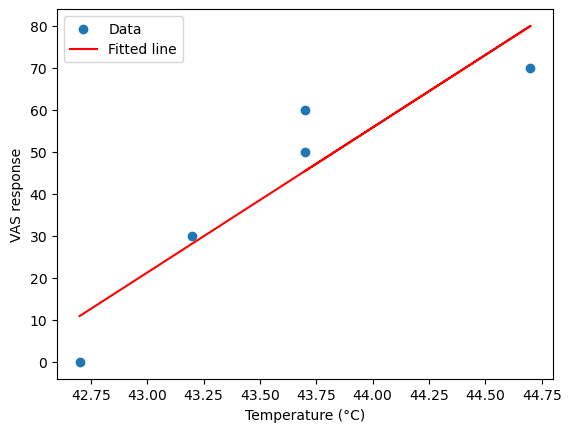

In [ ]:
x = fixed_temperatures
y = vas_responses
print(f"{fixed_temperatures = }\n{vas_responses = }")

slope, intercept = np.polyfit(x, y, 1)
y_pred = slope * x + intercept

plt.scatter(x, y, label='Data')
plt.plot(x, y_pred, color='red', label='Fitted line')
plt.xlabel('Temperature (°C)')
plt.ylabel('VAS response')
plt.legend()
plt.show()


In [ ]:
fixed_temperatures

array([42.7, 43.2, 43.7, 44.7, 43.7])

In [ ]:
# Collect VAS responses for fixed VAS targets
fixed_vas_targets = [10, 30, 90]

for target in fixed_vas_targets:
    pred_temperature = np.round((target - intercept) / slope,1)
    vas_response = input(f'How painful was {pred_temperature} °C on a scale from 0 to 100?')
    vas_responses.append(int(vas_response))
    temperatures.append(pred_temperature)
    logger.info(f"Calibration psychometric-perceptual scaling: {pred_temperature} °C was rated {vas_response} on the VAS scale.")
    
    slope, intercept = np.polyfit(
        np.array(temperatures[-len(fixed_vas_targets):]), 
        np.array(vas_responses[-len(fixed_vas_targets):]), 
        1)


INFO: Calibration psychometric-perceptual scaling: 42.7 °C was rated 10 on the VAS scale.
INFO: Calibration psychometric-perceptual scaling: 42.7 °C was rated 30 on the VAS scale.
C:\Users\visser\AppData\Local\Temp\ipykernel_1764\1832210150.py:11: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(
INFO: Calibration psychometric-perceptual scaling: 187.9 °C was rated 90 on the VAS scale.


In [ ]:
x = temperatures
y = vas_responses
print(f"{fixed_temperatures = }\n{vas_responses = }")

slope, intercept = np.polyfit(x, y, 1)
y_pred = slope * x + intercept

plt.scatter(x, y, label='Data')
plt.plot(x, y_pred, color='red', label='Fitted line')
plt.xlabel('Temperature (°C)')
plt.ylabel('VAS response')
plt.legend()
plt.show()

fixed_temperatures = array([42.7, 43.2, 43.7, 44.7, 43.7])
vas_responses = [0, 30, 50, 70, 60, 10, 30, 90]


TypeError: expected x and y to have same length

In [ ]:
np.array(temperatures[:-len(fixed_vas_targets)]), 
# np.array(vas_responses[-len(fixed_vas_targets)]), 

(array([39. , 40.7, 42. , 43. , 42.4, 42.8, 42.5, 42.7]),)

In [ ]:
a = [24,1,234,342,4]
a[-2:]

[342, 4]

In [ ]:
vas_responses, temperatures

([0, 30, 50, 70, 60, 10, 30, 90],
 [39.0, 40.7, 42.0, 43.0, 42.4, 42.8, 42.5, 42.7, 42.7, 42.7, 187.9])

In [ ]:
y_pred = 35
(y_pred - intercept) / slope

73.81428571428576

## Section 6: Calibration validation

## Module usage: calibration.py

In [ ]:
threshold_estimator = PainThresholdEstimator(mean_temperature=39)

for trial in range(threshold_estimator.trials):
    response = input(f'Is {threshold_estimator.current_temperature} °C painful? (y/n) ')
    threshold_estimator.conduct_trial(response,trial=trial)

print(f"Calibration pain threshold estimate: {threshold_estimator.get_estimate()} °C")
